In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [88]:
from pandas.api.types import CategoricalDtype

df = pd.read_csv('results.csv')
errors_order = CategoricalDtype(["none", "single", "half"], ordered=True)
df.errors = df.errors.astype(errors_order)
df

,database,dataset,scale,variant,errors,time
0,neo4j,recommendations,1.0,full,none,1825
1,neo4j,recommendations,1.0,full,none,1327
2,neo4j,recommendations,1.0,full,none,1274
3,neo4j,recommendations,1.0,boolean,none,1713
4,neo4j,recommendations,1.0,boolean,none,1515
...,...,...,...,...,...,...
73,tigergraph,snb,1.0,full,none,1037
74,tigergraph,snb,1.0,full,none,1009
75,tigergraph,snb,1.0,boolean,none,1009
76,tigergraph,snb,1.0,boolean,none,1026


In [89]:
def format(str):
    if str.lower() == "neo4j":
        return "Neo4j"
    if str.lower() == "janusgraph":
        return "JanusGraph"
    if str.lower() == "tigergraph":
        return "TigerGraph"
    if str.lower() == "snb":
        return "SNB"
    return str.capitalize()

In [90]:
full_vs_boolean = df[(df.database == "neo4j") & (df.scale == 0.1) & (df.errors == "none")]
full = full_vs_boolean[full_vs_boolean.variant == "full"].time
boolean = full_vs_boolean[full_vs_boolean.variant == "boolean"].time

t_stat, p_value = stats.ttest_ind(full, boolean)
print(f"p={p_value}, T={t_stat}")

p=6.194487656700258e-06, T=31.318427085384315


In [91]:
compare_error_rates = df[(df.database == "neo4j") & (df.scale == 0.1) & (df.variant == "boolean")]
none = compare_error_rates[compare_error_rates.errors == "none"].time
single = compare_error_rates[compare_error_rates.errors == "single"].time
half = compare_error_rates[compare_error_rates.errors == "half"].time

t_stat, p_value = stats.ttest_ind(none, single)
print(f"none vs single: p={p_value:.5f}, T={t_stat:.5f}")

t_stat, p_value = stats.ttest_ind(single, half)
print(f"single vs half: p={p_value:.5f}, T={t_stat:.5f}")

t_stat, p_value = stats.ttest_ind(none, half)
print(f"none vs half:   p={p_value:.5f}, T={t_stat:.5f}")

none vs single: p=0.27207, T=1.27270
single vs half: p=0.02018, T=3.73659
none vs half:   p=0.00375, T=6.05840


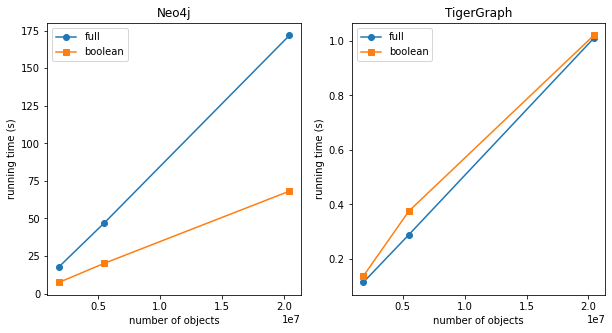

In [92]:
df_num_elements = pd.DataFrame([
    ["recommendations", 1.0, 28_863, 166_261, 0],
    ["snb", 0.1, 327_588, 1_477_965, 0],
    ["snb", 0.3, 908_224, 4_583_118, 0],
    ["snb", 1.0, 3_181_724, 17_256_038, 0]
], columns=["dataset", "scale", "nodes", "edges", "elements"])

df_num_elements.elements = df_num_elements.nodes + df_num_elements.edges

def plot_scale_per_db(ax, db):
    df_filtered = df[
        (df.database == db) & (df.dataset == "snb") & (df.errors == "none")
    ]
    df_merged = pd.merge(df_filtered, df_num_elements, on=["dataset", "scale"])

    full = df_merged[df_merged.variant == "full"].groupby("elements").mean().reset_index()
    boolean = df_merged[df_merged.variant == "boolean"].groupby("elements").mean().reset_index()

    ax.plot(full.elements, full.time / 1000, "o-", label="full")
    ax.plot(boolean.elements, boolean.time / 1000, "s-", label="boolean")
    ax.set_xlabel("number of objects")
    ax.set_ylabel("running time (s)")
    ax.set_title(format(db))
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_scale_per_db(axs[0], "neo4j")
plot_scale_per_db(axs[1], "tigergraph")
plt.show()

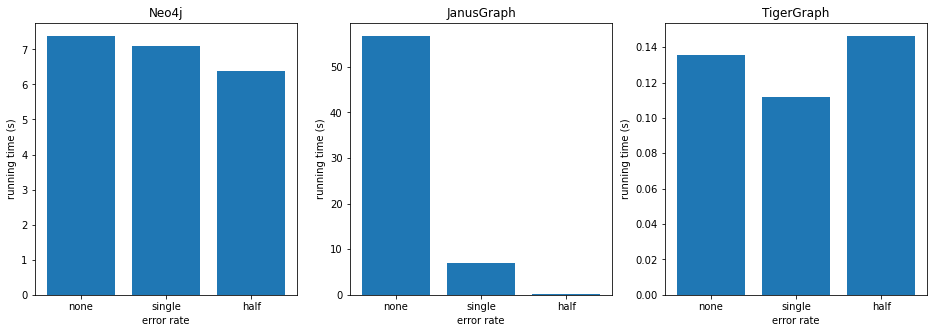

In [109]:
def plot_errors_per_db(ax, db):
    df_filtered = df[
        (df.database == db) & (df.dataset == "snb") & (df.scale == 0.1) & (df.variant == "boolean")
    ]

    data = df_filtered.groupby("errors").mean().reset_index()
    
    ax.bar(data.errors, data.time / 1000)
    ax.set_xlabel("error rate")
    ax.set_ylabel("running time (s)")
    ax.set_title(format(db))

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
plot_errors_per_db(axs[0], "neo4j")
plot_errors_per_db(axs[1], "janusgraph")
plot_errors_per_db(axs[2], "tigergraph")
plt.show()